In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [86]:
default_params = {
    'plot_edge_image': True,
    'showG0Points': True,
    'showG1Points': True,
    'showG0Lines': True,
    'showG1Lines': True
}
def plot_edge_approx2(edge_image, edge_points, feed_points, figsize=(5, 5), params=default_params):


    height, width = edge_image.shape[:2]
    slope = (0.1 - 1.0) / (750 - 10)
    intercept = 1.0 - (0.1 - 1.0) / (750 - 10) * 10
    rf = slope * (height + width) / 2 + intercept

    fig = plt.figure(figsize=figsize)

    # Plot des Edge-Bildes
    if params['plot_edge_image']:
       plt.imshow(edge_image, cmap='gray')
    else:
        fig.patch.set_facecolor('black')
        plt.gca().invert_yaxis()

    # Plot der approximierten Kanten als Linien mit blauer Farbe
    for i in range(0, len(edge_points)):
        edge_approx = edge_points[i]
        feed_point = feed_points[i]
        
        # Plot G1
        segment_ended = False
        g1_segments = []
        g1_segment_points = []
        for j, value in enumerate(feed_point):
            if segment_ended:
                g1_segment_points.append(edge_approx[j-1])
                segment_ended = False
                
            if value:
                g1_segment_points.append(edge_approx[j])
            elif len(g1_segment_points) != 0:
                g1_segments.append(g1_segment_points)
                g1_segment_points = []
                segment_ended = True
        if len(g1_segment_points) != 0:
            g1_segments.append(g1_segment_points)

        for g1_points in g1_segments:
            g1_x_approx = [x for x, y in g1_points]
            g1_y_approx = [y for x, y in g1_points]

            # Plot G1 Linien
            if params['showG1Lines']:
                plt.plot(g1_x_approx, g1_y_approx, color='red', markersize=5*rf)
            
            # Plot der Eckpunkte als rote Punkte
            if params['showG1Points']:
                plt.plot(g1_x_approx, g1_y_approx, 'ro', markersize=5*rf)

        # Plot G0
        g0_points = [[edge_approx[j-1], edge_approx[j]] for j in [i for i, value in enumerate(feed_point) if value == False]]
        if len(g0_points) != 0:
            for g0_point in g0_points:
                g0_x_approx = [g0_point[0][0], g0_point[1][0]]
                g0_y_approx = [g0_point[0][1], g0_point[1][1]]

                # Plot G0 Linien
                if params['showG0Lines']:
                    plt.plot(g0_x_approx, g0_y_approx, color='green', linestyle='--', markersize=5*rf*0.5)

                # Plot der Eckpunkte als rote Punkte
                if params['showG0Points']:
                    plt.plot(g0_point[1][0], g0_point[1][1], 'o', color='green', markersize=4*rf*0.5)

    plt.title('Edge Approximation')

    # Anpassung der Achsenskalierung
    plt.axis('scaled')

    plt.savefig('image.png')

    # Anzeigen des Diagramms
    plt.show()

In [77]:
def getContourApproximation(edge_image, epsilon, min_contour_len=0):
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    feed_points = []
    contour_segments = []
    # k = 0
    for contour in contours:
        if len(contour) < min_contour_len:
            continue

        # print(f'{k} \ {len(contours)}')
        # k += 1

        # Edge Approximation
        approx = [tuple(point[0]) for point in cv2.approxPolyDP(contour, epsilon, True).tolist()]
        contour = [tuple(point[0]) for point in contour.tolist()]

        # print('contour', contour, '\n')
        # print('approx', approx, '\n')

        rescent_index = 0
        used_contour_points = None
        start_point = None

        feed_point = []
        segment = []
        for i in range(len(approx)):
            if i == 0:
                start_point = approx[i]
                segment.append(start_point)
                feed_point.append(True)
                # print('startPoint Indexes', np.where((np.array(contour) == start_point).all(axis=1))[0])
            end_point = approx[(i+1) % len(approx)]

            # Find Index
            indexes = np.where((np.array(contour) == end_point).all(axis=1))[0]
            if indexes.size == 0:
                break

            # Get Index Position 
            closest_index = min((x for x in indexes if x >= rescent_index or x == 0), default=None, key=lambda x: abs(x - rescent_index))
            index = closest_index if closest_index != None else min((x for x in indexes if x >= 0 or x == 0), default=None, key=lambda x: abs(x - rescent_index))
            
            # Inizialisierung des recent_index
            # if i == 0:
                # sP_indexes = np.where((np.array(contour) == start_point).all(axis=1))[0]
                # rescent_index = min(sP_indexes, key=lambda x: abs(x - index)) if 0 not in sP_indexes else 0

            # Die Konturpunkte des Segments
            segment_contour_points = None
            if rescent_index == index:
                segment_contour_points = [contour[index]]
            elif i == len(approx) - 1:
                segment_contour_points = contour[rescent_index:] + contour[:index]
            elif rescent_index < index:
                segment_contour_points = contour[rescent_index: index]
            elif rescent_index > index:
                segment_contour_points = contour[index: rescent_index]

            # print('\niteration:', i, 'indexes', indexes)
            # print('recentIndex', rescent_index, 'index', index, 'end_point', end_point, 'len(contour)', len(contour))
            # print('segment', len(segment_contour_points))
            # print('used_contour_points', len(used_contour_points) if i != 0 else used_contour_points)
            # print('is in', not set(used_contour_points).issuperset(segment_contour_points) if i != 0 else True)
            # print('used_contour_points', used_contour_points)
            
            # Check if Contour Points are already used
            if not set(used_contour_points).issuperset(segment_contour_points) if i != 0 else True:
                if i == 0:
                    used_contour_points = segment_contour_points
                else:
                    used_contour_points += segment_contour_points
                feed_point.append(True)
            else:
                # print('!!!!!!!! END !!!!!!!!!!')
                # break
                feed_point.append(False)
                # continue

            rescent_index = index + 1
            segment.append(end_point)

        contour_segments.append(segment)
        feed_points.append(feed_point)

    return contour_segments, feed_points

## 1. Tests
---



 Result:
edge_points (1, 0),(1, 3),(2, 4),(1, 5),(2, 6),(1, 7),(2, 8),(9, 8),(9, 0),(9, 3),(8, 4),(2, 4),(1, 3),(1, 0)
feed_points [[True, True, True, True, True, True, True, True, True, False, True, True, True, False]]


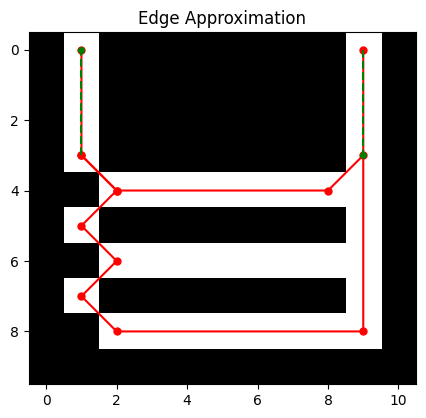

In [78]:
edge_image = np.array([
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0,   0, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation(edge_image, 0)

print('\n\n Result:')
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)



 Result:
edge_points (1, 0),(1, 8),(9, 8),(9, 0),(9, 3),(8, 4),(2, 4),(1, 3),(1, 0)
feed_points [[True, True, True, True, False, True, True, False, False]]


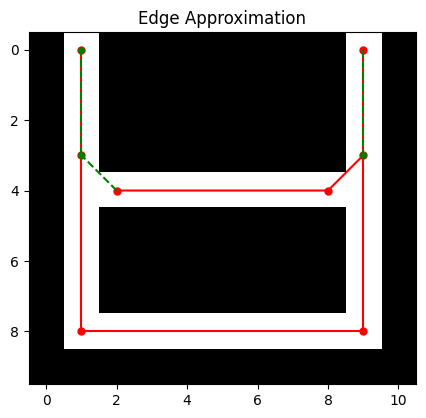

In [79]:
edge_image = np.array([
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255,   0,   0,   0,   0,   0,   0,   0, 255,   0],
       [  0, 255, 255, 255, 255, 255, 255, 255, 255, 255,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation(edge_image, 0)

print('\n\n Result:')
print('edge_points', ','.join([str(k) for k in edge_points[0]]))
print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

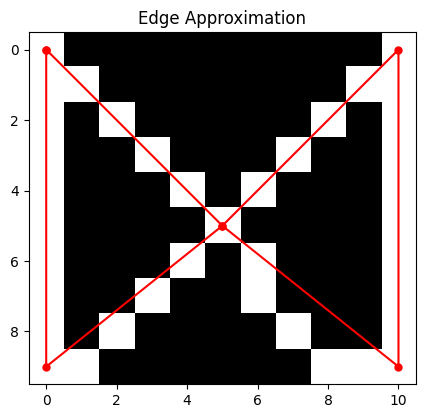

In [96]:
edge_image = np.array([
       [255,   0,   0,   0,   0,   0,   0,   0,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0,   0,   0, 255, 255],
       [255,   0, 255,   0,   0,   0,   0,   0, 255,   0, 255],
       [255,   0,   0, 255,   0,   0,   0, 255,   0,   0, 255],
       [255,   0,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0,   0,   0, 255,   0,   0,   0,   0, 255],
       [255,   0,   0,   0, 255,   0, 255,   0,   0,   0, 255],
       [255,   0,   0, 255,   0,   0, 255,   0,   0,   0, 255],
       [255,   0, 255,   0,   0,   0,   0, 255,   0,   0, 255],
       [255, 255,   0,   0,   0,   0,   0,   0, 255, 255, 255]]).astype(np.uint8)


edge_points, feed_points = getContourApproximation(edge_image, 3)

# print('\n\n Result:')
# print('edge_points', ','.join([str(k) for k in edge_points[0]]))
# print('feed_points', feed_points)
plot_edge_approx2(edge_image, edge_points, feed_points)

In [80]:
def find_closest_value(lst, target):
    closest = min((x for x in lst if x > target), default=None, key=lambda x: abs(x - target))
    return closest if closest is not None else 0

my_list = [1, 3, 5, 7, 9]
my_value = 6
closest_value = find_closest_value(my_list, my_value)
print(closest_value)  # Ausgabe: 7

my_list = [1, 3, 5]
my_value = 6
closest_value = find_closest_value(my_list, my_value)
print(closest_value)  # Ausgabe: 0


7
0


In [167]:
import base64
import time

preloaded_images = None
with open("../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

edge_image = cv2.Canny(gray, 50, 150)

start_time = time.time()
edge_points, feed_points = getContourApproximation(edge_image, 1, 5)
print('duration', time.time() - start_time)

print('edge_points', edge_points)
print('feed_points', feed_points)

duration 8.03385877609253
edge_points [[(750, 765), (746, 767), (750, 767), (750, 765)], [(504, 766), (505, 765), (506, 767), (509, 767), (505, 765), (504, 766)], [(737, 764), (743, 767), (743, 764), (737, 764)], [(721, 765), (730, 767), (727, 764), (724, 764), (723, 766), (721, 765)], [(599, 764), (603, 765), (604, 767), (604, 765), (599, 764)], [(520, 764), (518, 764), (519, 765), (516, 767), (520, 764)], [(663, 763), (661, 767), (663, 766), (661, 766), (663, 763)], [(556, 763), (558, 764), (557, 766), (561, 767), (561, 765), (567, 767), (575, 767), (571, 765), (573, 763), (571, 763), (571, 765), (565, 763), (567, 762), (556, 763)], [(516, 763), (515, 762), (512, 766), (514, 766), (513, 765), (516, 763)], [(428, 762), (430, 763), (428, 764), (432, 763), (428, 762)], [(478, 765), (474, 761), (471, 767), (468, 765), (469, 763), (466, 767), (464, 766), (465, 763), (461, 767), (466, 767), (468, 765), (469, 767), (472, 767), (476, 763), (478, 765)], [(179, 760), (180, 763), (183, 764), (1

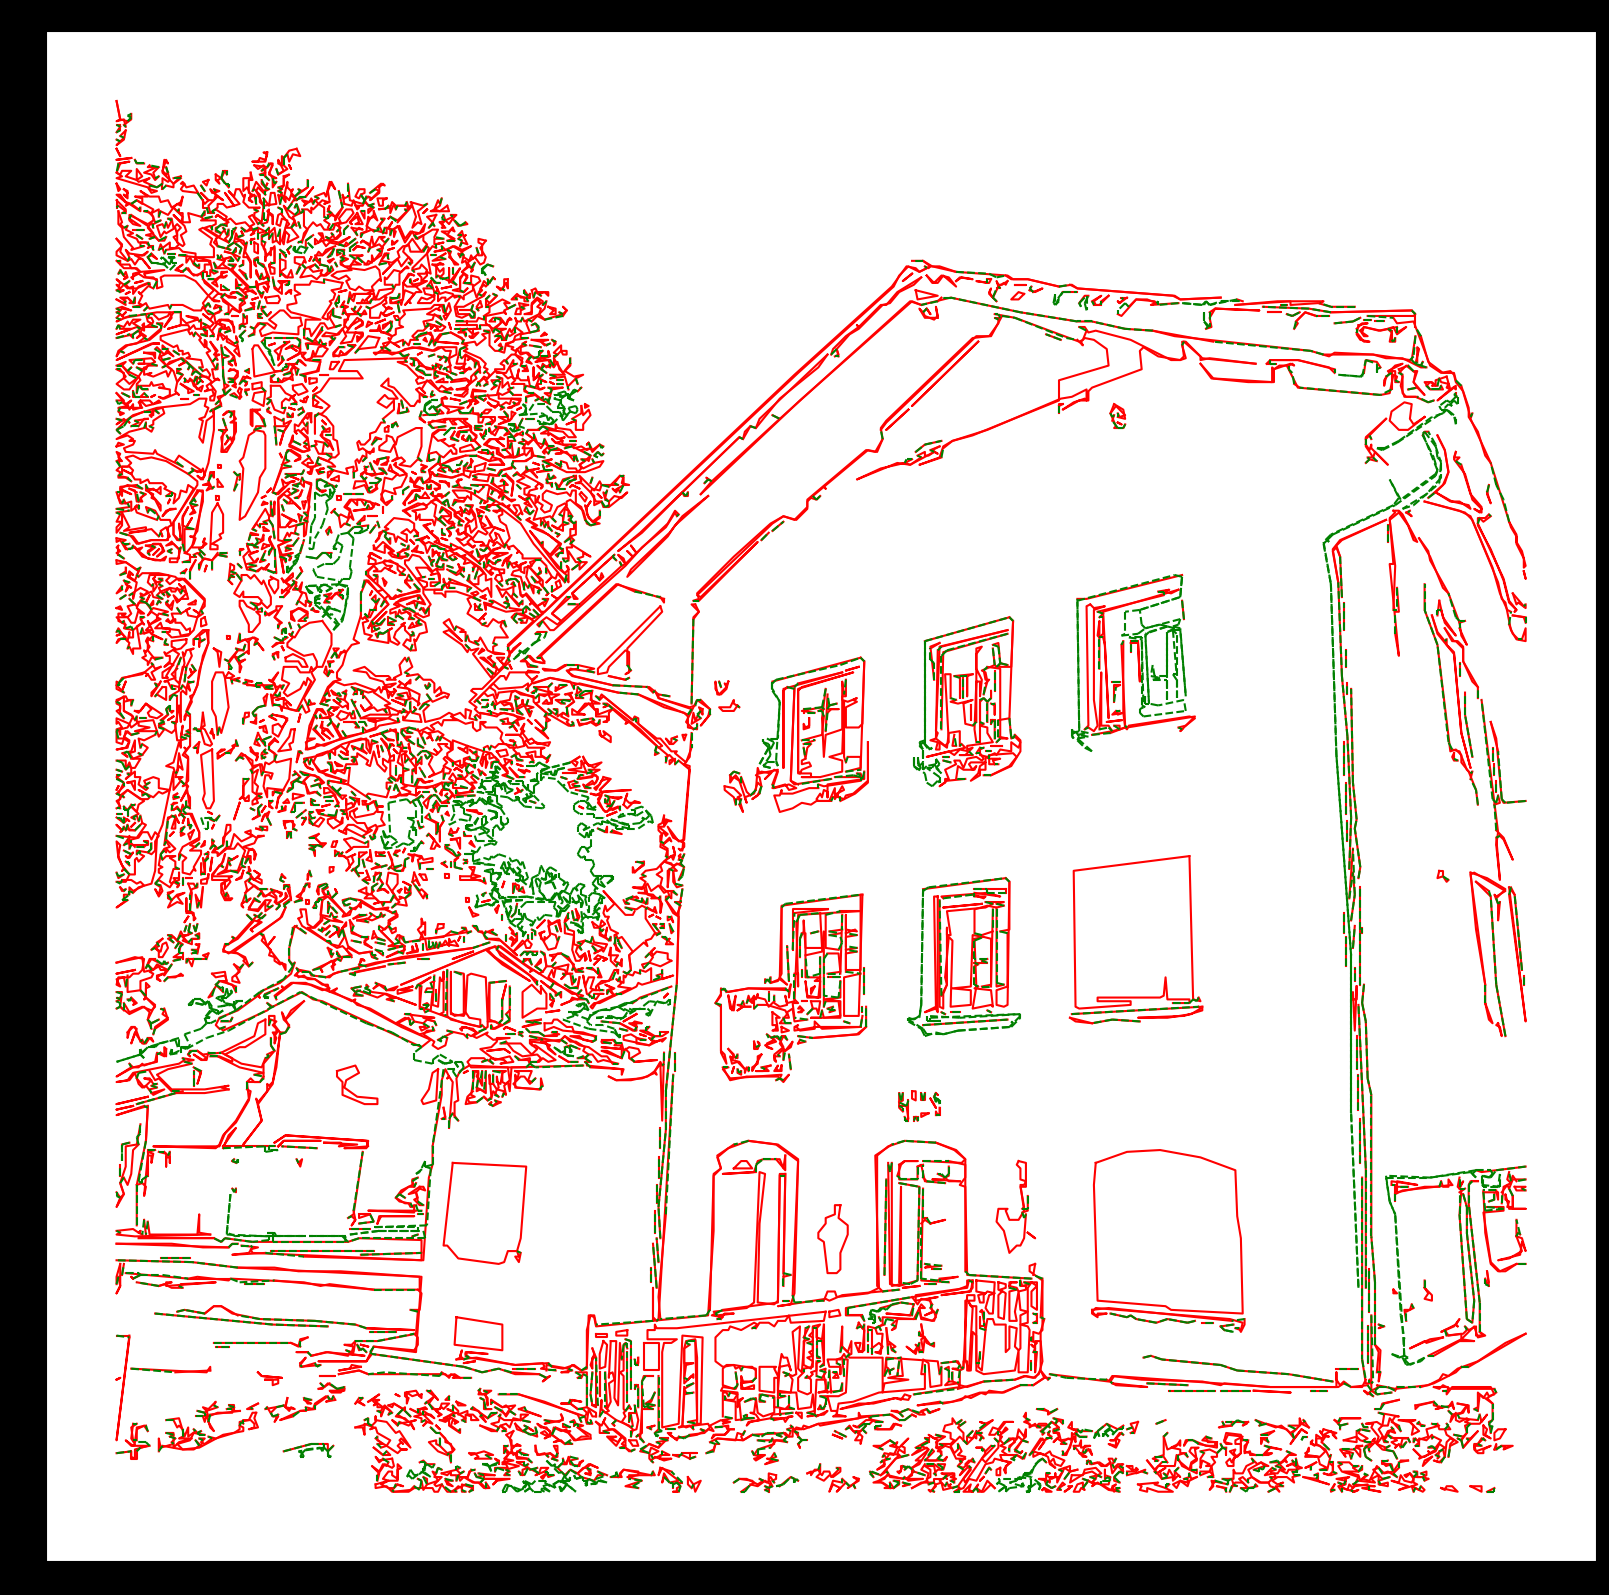

In [169]:
params = {
    'plot_edge_image': False,
    'showG0Points': False,
    'showG1Points': False,
    'showG0Lines': True,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, edge_points, feed_points, (20, 20), params)

In [125]:
def find_index_most_false(lst):
    counts = [sublist.count(False) for sublist in lst]
    return counts.index(max(counts))

# Beispielaufruf

index_most_false = find_index_most_false(feed_points)
print(index_most_false)  # Ausgabe: 1

1551


In [103]:
len(edge_points[1019])

1165

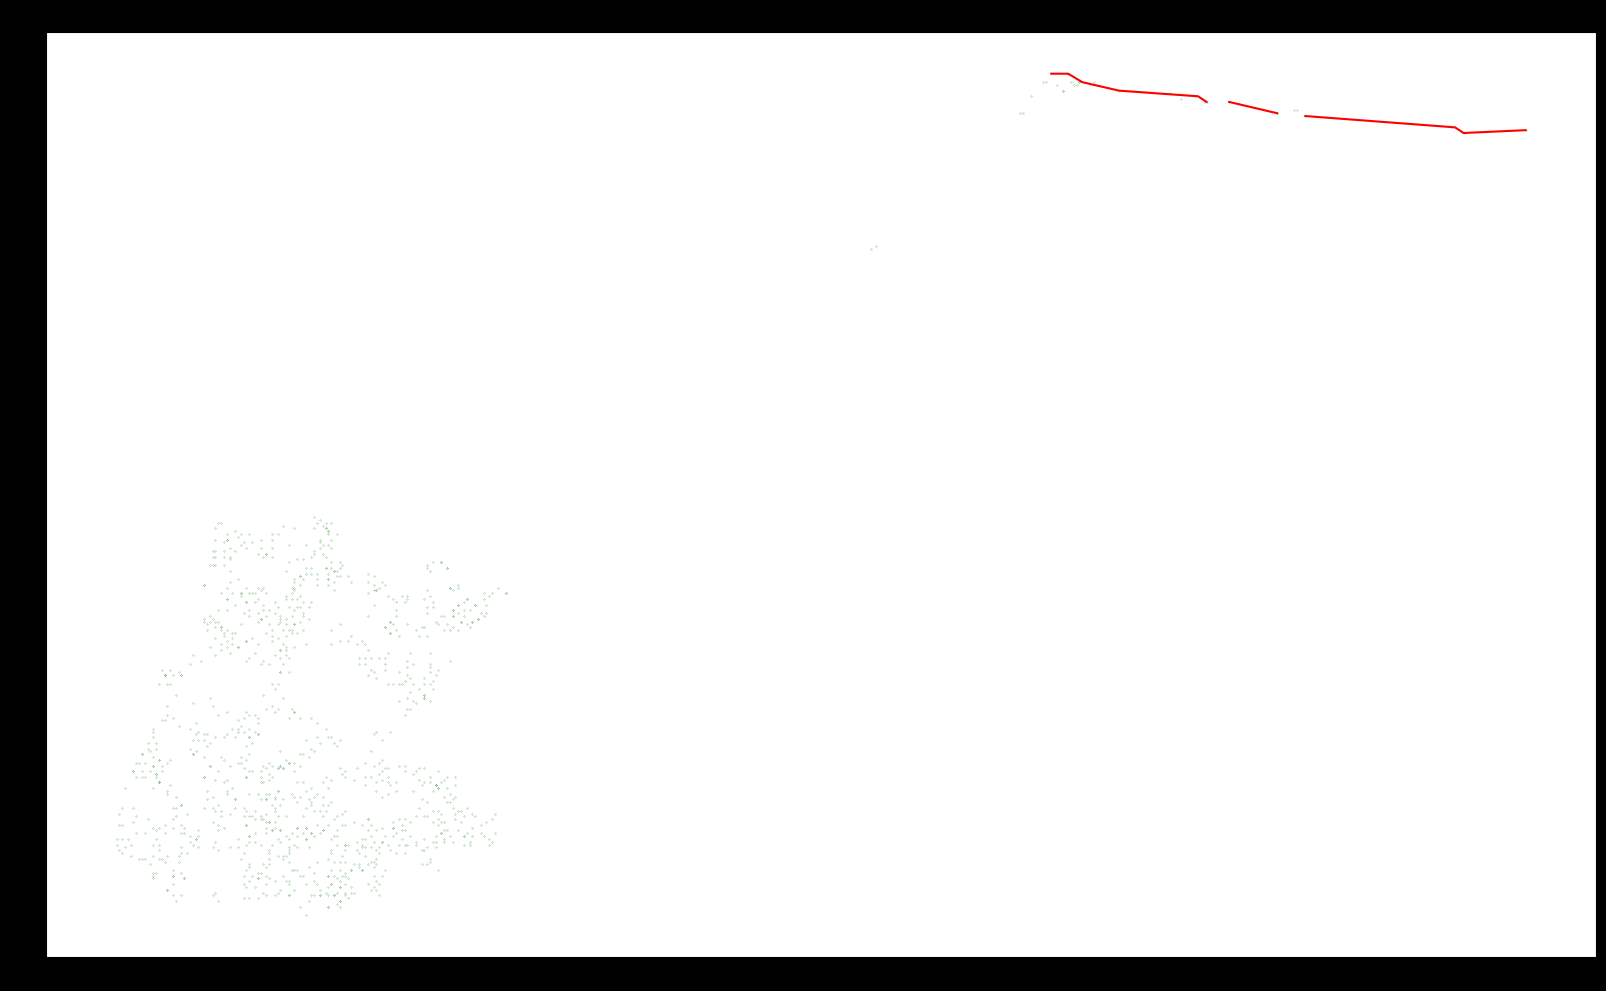

In [106]:
params = {
    'plot_edge_image': False,
    'showG0Points': True,
    'showG1Points': False,
    'showG0Lines': False,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, [edge_points[1019]], [feed_points[1019]], (20, 20), params)

In [109]:
print(len(feed_points[1019]))
print(feed_points[1019].count(False))

1165
1155


In [113]:
[edge_points[1019][i] for i in [index for index, value in enumerate(feed_points[1019]) if value]]

[(601, 117),
 (579, 118),
 (576, 116),
 (523, 112),
 (496, 107),
 (485, 105),
 (457, 103),
 (444, 100),
 (439, 97),
 (433, 97)]

In [311]:
def initialize_indexes(start_point_indexes, indexes, contour_lenth):
    closest_pair = None
    min_distance = float('inf')

    for rescent_index in start_point_indexes:
        for index in indexes:
            a = [contour_lenth - rescent_index + index, index - rescent_index]
            print('rescentIndex', rescent_index, 'index', index, 'dist', a)
            distace = min([dist for dist in a if dist > 0])
            if distace < min_distance:
                closest_pair = (rescent_index, index)
                min_distance = distace
                
    return closest_pair, min_distance



start_point_indexes = [0, 499]
indexes = [501, 652]
contour_lenth = 654
initialize_indexes(start_point_indexes, indexes, contour_lenth)

# startPoint Indexes [  0 499] len contour 654
# rescent_index 0 index 652 indexes [501 652] segment_length 652
# rescent_index 653 index 527 indexes [527 626] segment_length 528
# rescent_index 528 index 532 indexes [532] segment_length 4

rescentIndex 0 index 501 dist [1155, 501]
rescentIndex 0 index 652 dist [1306, 652]
rescentIndex 499 index 501 dist [656, 2]
rescentIndex 499 index 652 dist [807, 153]


((499, 501), 2)

In [316]:
def initialize_indexes(start_point_indexes, indexes, contour_lenth):
    closest_pair = None
    min_distance = float('inf')

    for rescent_index in start_point_indexes:
        for index in indexes:
            distace = min([dist for dist in [contour_lenth - rescent_index + index, index - rescent_index] if dist > 0])
            if distace < min_distance:
                closest_pair = (rescent_index, index)
                min_distance = distace
                
    return closest_pair

def getContourApproximation(edge_image, epsilon, min_contour_len=0):
    contours, _ = cv2.findContours(edge_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)

    feed_points = []
    contour_segments = []
    # k = 0
    for i, contour in enumerate(contours):
        # if i != 552:
        #     continue

        # print('coutour', contour)

        # if len(contour) < min_contour_len:
        #     continue

        # print(f'{k} \ {len(contours)}')
        # k += 1

        # Edge Approximation
        approx = [tuple(point[0]) for point in cv2.approxPolyDP(contour, epsilon, True).tolist()]
        contour = [tuple(point[0]) for point in contour.tolist()]

        # print('contour', contour, '\n')
        # print('approx', approx, '\n')

        rescent_index = 0
        used_contour_points = None
        start_point = None

        feed_point = []
        segment = []
        for i in range(len(approx)):
            if i == 0:
                start_point = approx[i]
                segment.append(start_point)
                feed_point.append(True)

            end_point = approx[(i+1) % len(approx)]

            # Reset indexes
            indexes = np.where((np.array(contour) == end_point).all(axis=1))[0]
            if indexes.size == 0:
                break

            if i == 0:
                start_point_indexes = np.where((np.array(contour) == start_point).all(axis=1))[0]
                # print('startPoint Indexes', start_point_indexes, 'len contour', len(contour))
                if len(start_point_indexes) != 1:
                    rescent_index, index = initialize_indexes(start_point_indexes, indexes, len(contour))
                else:
                    rescent_index = start_point_indexes[0]
                    closest_index = min((x for x in indexes if x >= rescent_index), default=None, key=lambda x: abs(x - rescent_index))
                    index = closest_index if closest_index != None else min((x for x in indexes if x >= 0 or x == 0), default=None, key=lambda x: abs(x - 0))
            else:
                closest_index = min((x for x in indexes if x >= rescent_index), default=None, key=lambda x: abs(x - rescent_index))
                index = closest_index if closest_index != None else min((x for x in indexes if x >= 0 or x == 0), default=None, key=lambda x: abs(x - 0))


            # Set indexes
            # Set initial rescent index
            # start_point_indexes = np.where((np.array(contour) == start_point).all(axis=1))[0]
            # rescent_index = start_point_indexes[0]

            # Find Index
            # indexes = np.where((np.array(contour) == end_point).all(axis=1))[0]
            # if indexes.size == 0:
            #     break


            # Get Index Position 
            # closest_index = min((x for x in indexes if x >= rescent_index), default=None, key=lambda x: abs(x - rescent_index))
            # index = closest_index if closest_index != None else min((x for x in indexes if x >= 0 or x == 0), default=None, key=lambda x: abs(x - 0))

            # if i == 0:
            #     start_point_indexes = np.where((np.array(contour) == start_point).all(axis=1))[0]


            # Die Konturpunkte des Segments
            segment_contour_points = None
            if rescent_index == index:
                segment_contour_points = [contour[index]]
            elif i == len(approx) - 1:
                segment_contour_points = contour[rescent_index:] + contour[:index]
            elif rescent_index < index:
                segment_contour_points = contour[rescent_index: index]
            elif rescent_index > index:
                 segment_contour_points = contour[rescent_index: len(contours)] + contour[0: index]
            # elif rescent_index > index:
            #     segment_contour_points = contour[index: rescent_index]

            # print('rescent_index', rescent_index, 'index', index, 'indexes', indexes, 'segment_length', len(segment_contour_points))

            # print('\niteration:', i, 'indexes', indexes)
            # print('recentIndex', rescent_index, 'index', index, 'end_point', end_point, 'len(contour)', len(contour))
            # print('segment', len(segment_contour_points))
            # print('used_contour_points', len(used_contour_points) if i != 0 else used_contour_points)
            # print('is in', not set(used_contour_points).issuperset(segment_contour_points) if i != 0 else True)
            # print('used_contour_points', used_contour_points)
            
            # Check if Contour Points are already used
            if not set(used_contour_points).issuperset(segment_contour_points) if i != 0 else True:
                if i == 0:
                    used_contour_points = segment_contour_points
                else:
                    used_contour_points += segment_contour_points
                feed_point.append(True)
            else:
                # print('!!!!!!!! END !!!!!!!!!!')
                # break
                feed_point.append(False)
                # continue

            rescent_index = index + 1
            segment.append(end_point)

        contour_segments.append(segment)
        feed_points.append(feed_point)

    return contour_segments, feed_points



End
duration 7.625387191772461
edge_points [[(750, 765), (746, 767), (750, 767), (750, 765)], [(504, 766), (505, 765), (506, 767), (509, 767), (505, 765), (504, 766)], [(737, 764), (743, 767), (743, 764), (737, 764)], [(721, 765), (730, 767), (727, 764), (724, 764), (723, 766), (721, 765)], [(599, 764), (603, 765), (604, 767), (604, 765), (599, 764)], [(520, 764), (518, 764), (519, 765), (516, 767), (520, 764)], [(663, 763), (661, 767), (663, 766), (661, 766), (663, 763)], [(471, 763), (471, 763)], [(556, 763), (558, 764), (557, 766), (561, 767), (561, 765), (567, 767), (575, 767), (571, 765), (573, 763), (571, 763), (571, 765), (565, 763), (567, 762), (556, 763)], [(516, 763), (515, 762), (512, 766), (514, 766), (513, 765), (516, 763)], [(428, 762), (430, 763), (428, 764), (432, 763), (428, 762)], [(478, 765), (474, 761), (471, 767), (468, 765), (469, 763), (466, 767), (464, 766), (465, 763), (461, 767), (466, 767), (468, 765), (469, 767), (472, 767), (476, 763), (478, 765)], [(459,

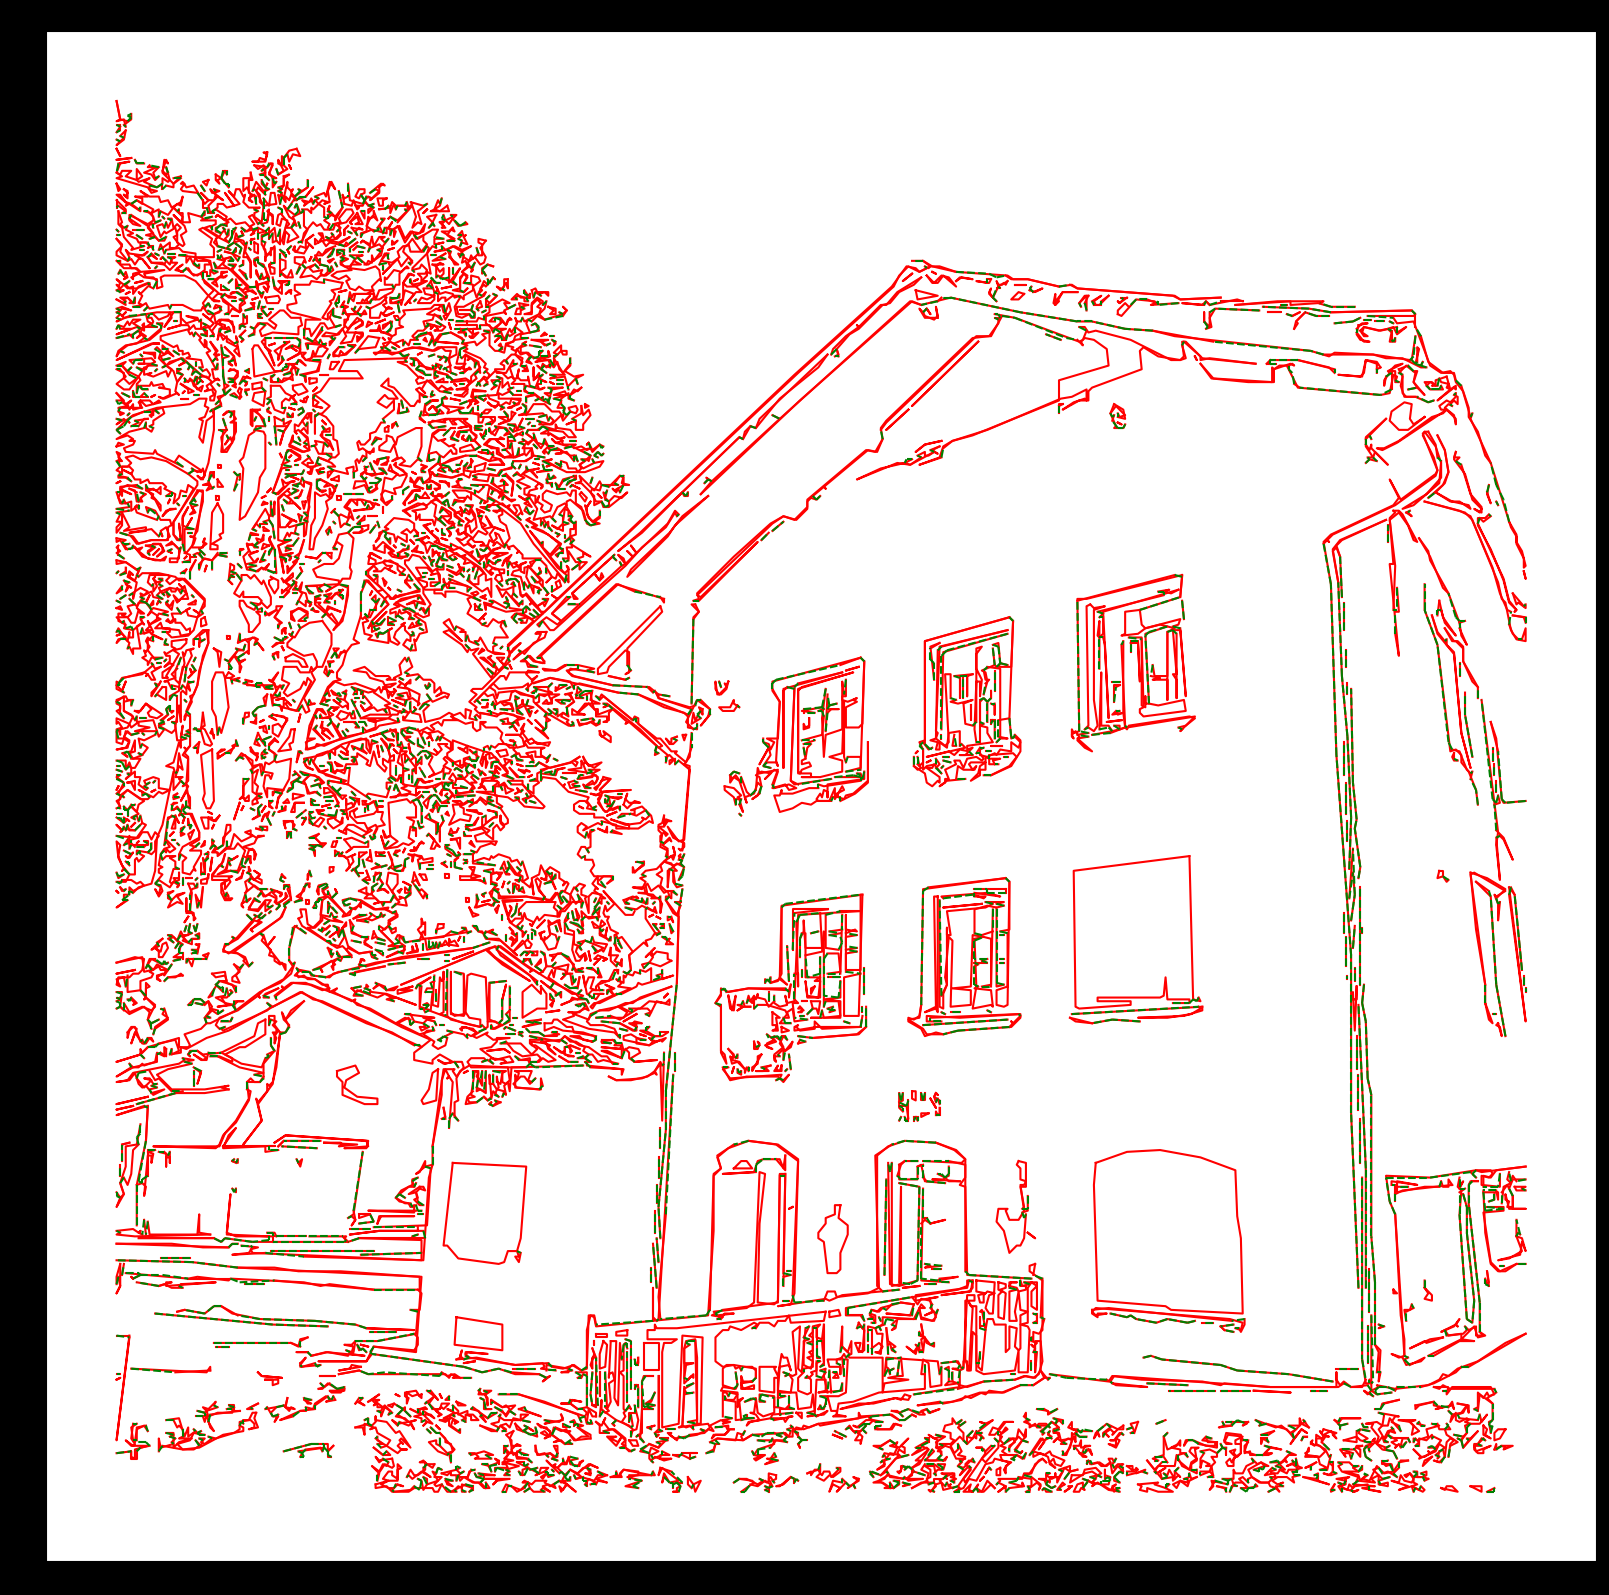

In [317]:
import base64
import time

preloaded_images = None
with open("../preloaded_images.txt", "r") as file:
    preloaded_images = eval(file.read())
selected_diff_image = preloaded_images[2]

# Convert image
decoded_image = base64.b64decode(selected_diff_image.split(',')[1])
image_array = np.frombuffer(decoded_image, dtype=np.uint8)
origial = cv2.imdecode(image_array, cv2.IMREAD_COLOR)

# Graustufenbild
gray = cv2.cvtColor(origial, cv2.COLOR_BGR2GRAY)

edge_image = cv2.Canny(gray, 50, 150)

start_time = time.time()
edge_points, feed_points = getContourApproximation(edge_image, 1, 5)

print('\n\nEnd')
print('duration', time.time() - start_time)

print('edge_points', edge_points)
print('feed_points', feed_points)

params = {
    'plot_edge_image': False,
    'showG0Points': False,
    'showG1Points': False,
    'showG0Lines': True,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, edge_points, feed_points, (20, 20), params)

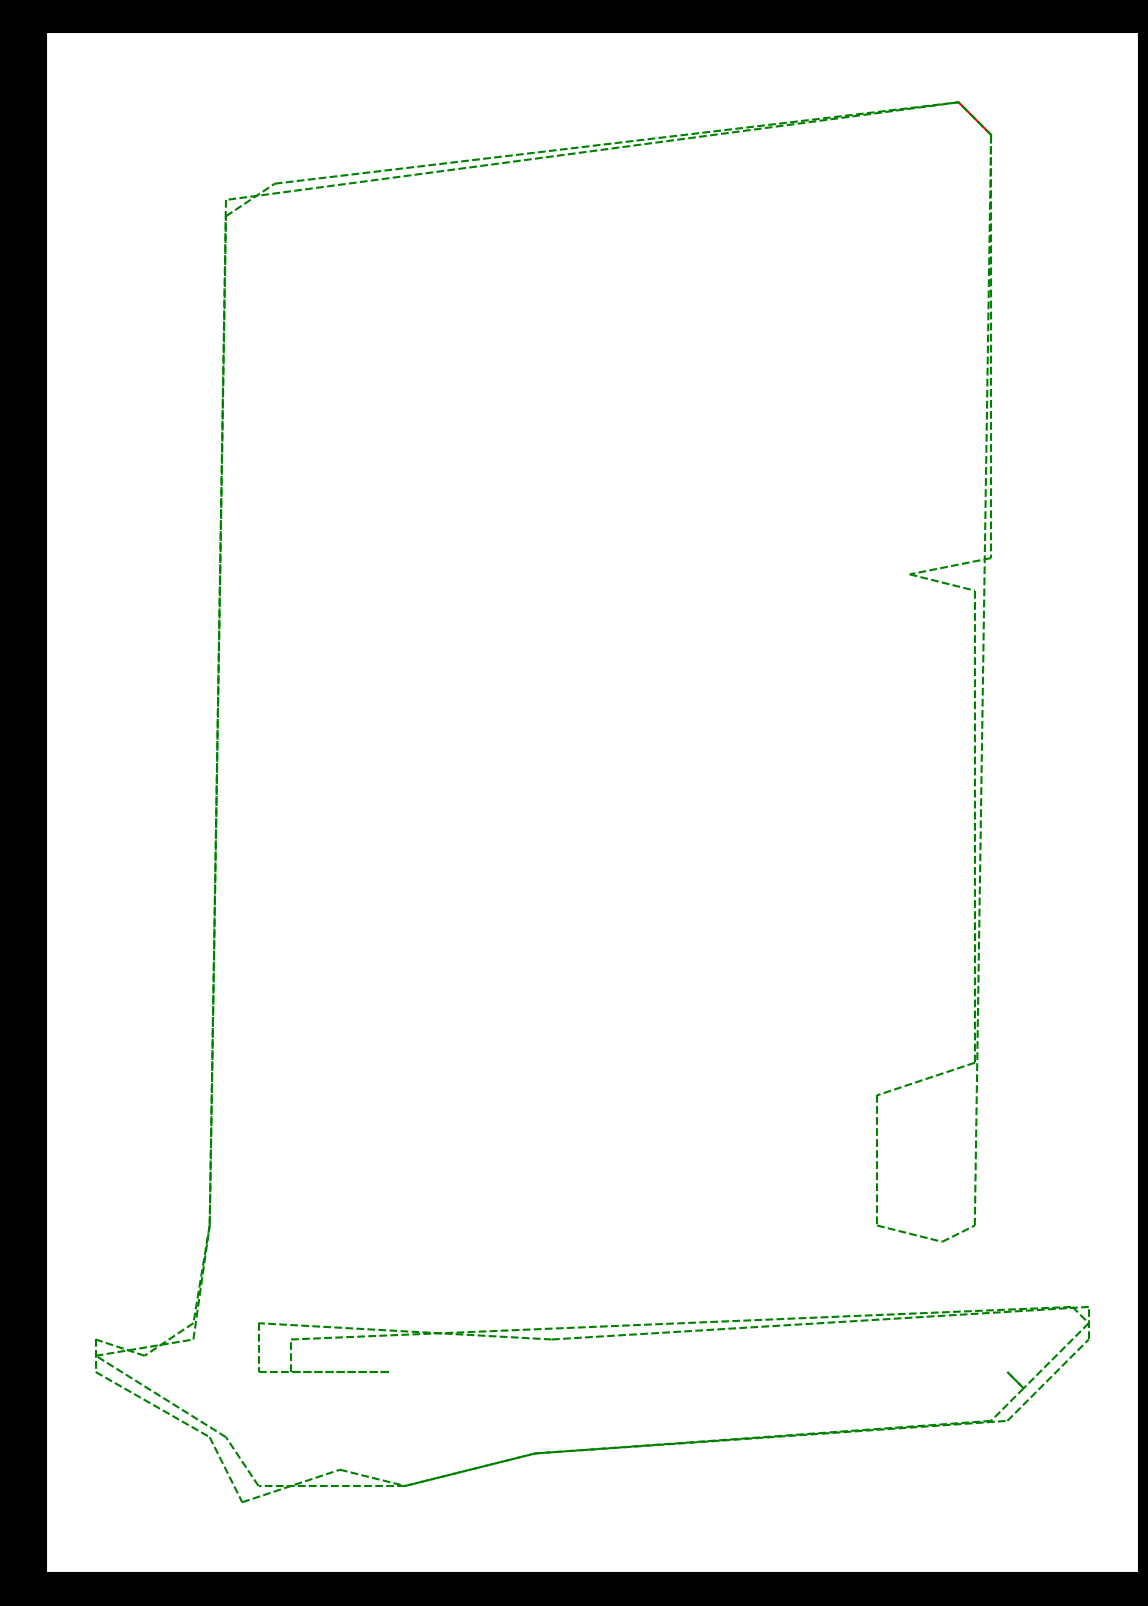

In [303]:
params = {
    'plot_edge_image': False,
    'showG0Points': False,
    'showG1Points': False,
    'showG0Lines': True,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, edge_points[552: 553], feed_points[552: 553], (20, 20), params)

In [239]:
def initialize_indexes(rescent_indexes, indexes, contour_lenth):
    closest_pair = None
    min_distance = float('inf')

    for rescent_index in rescent_indexes:
        for index in indexes:
            if rescent_index < index:
                distace = min(contour_lenth - index + rescent_index, index - rescent_index)
                if distace < min_distance:
                    closest_pair = (rescent_index, index)
                    min_distance = distace
                
    return closest_pair


rescent = [0, 499]
current = [501, 652]
closest_pair = initialize_indexes(rescent, current, 654)
print(closest_pair)



(0, 652)


In [235]:
rescent = [0, 499]
current = [501, 652]
closest_pair = min((r, c) for r in rescent for c in current if r < c)
print(closest_pair)

(0, 501)


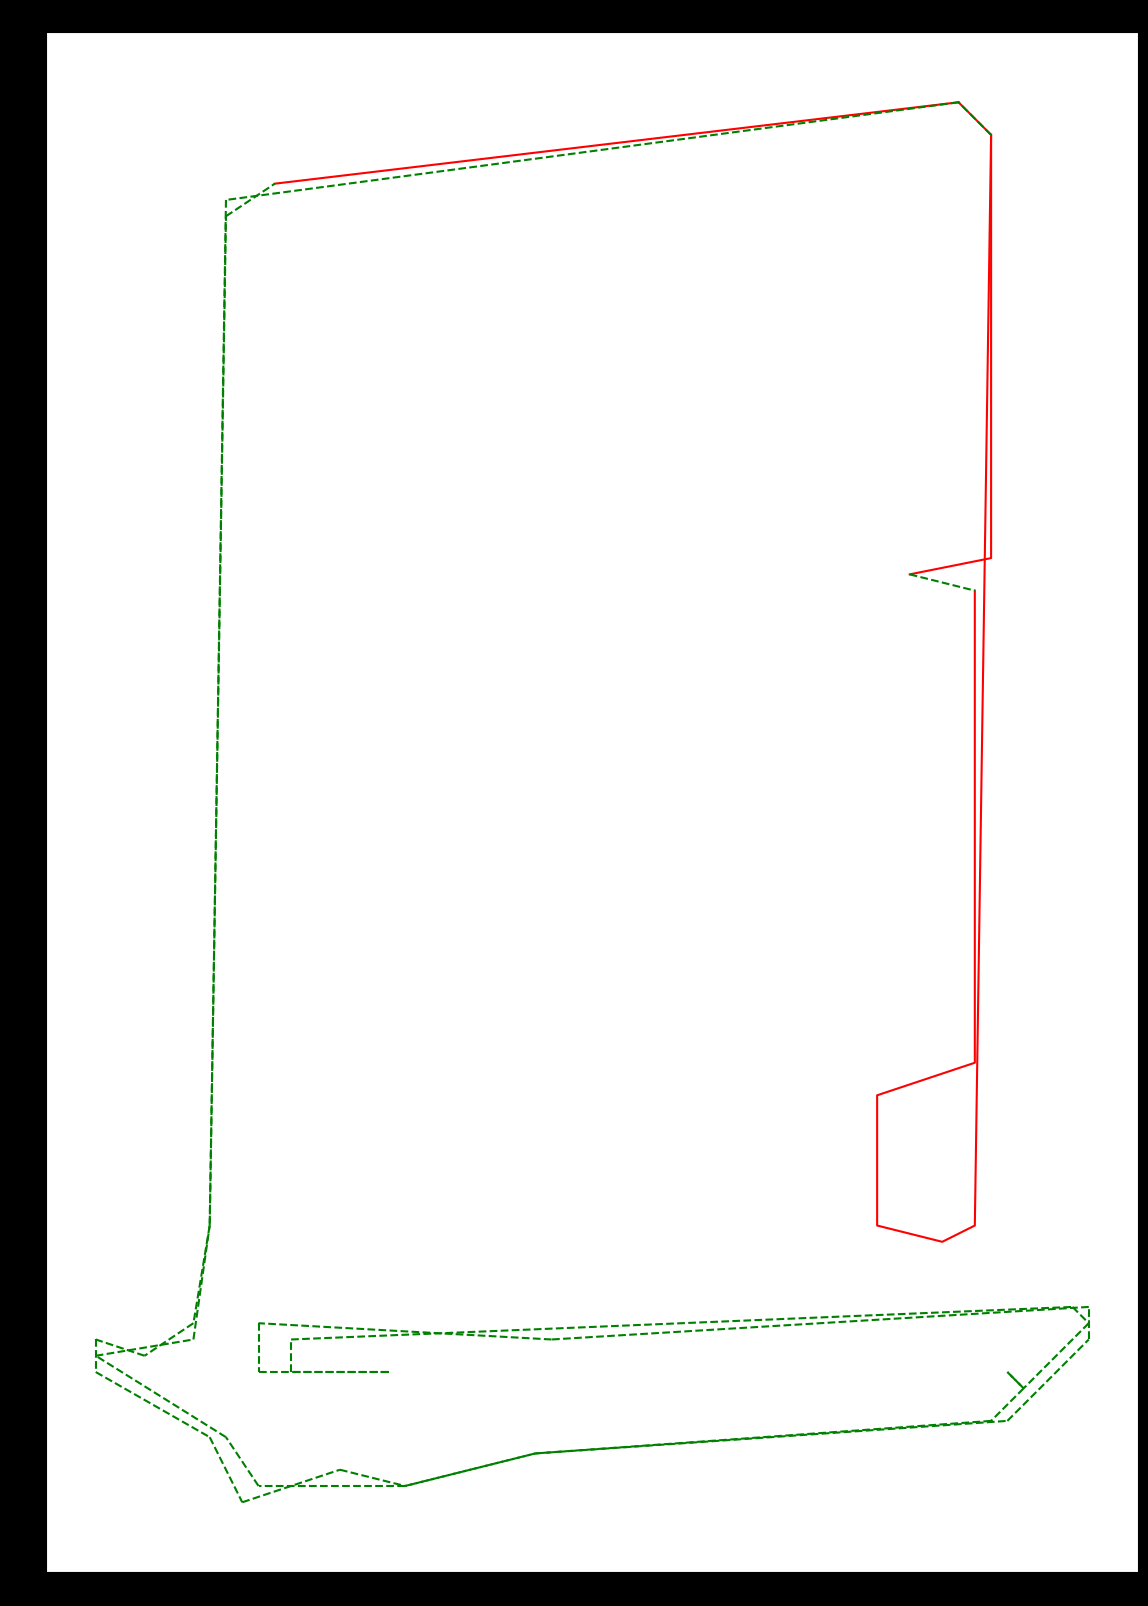

In [224]:
params = {
    'plot_edge_image': False,
    'showG0Points': False,
    'showG1Points': False,
    'showG0Lines': True,
    'showG1Lines': True
}
plot_edge_approx2(edge_image, edge_points[552:553], feed_points[552:553], (20, 20), params)

In [274]:
def find_indices_most_false(lst, n):
    counts = [sublist.count(False) for sublist in lst]
    sorted_indices = sorted(range(len(counts)), key=lambda i: counts[i], reverse=True)
    return sorted_indices[:n]

# Beispielaufruf für die Top 10 Werte

top_10_indices = find_indices_most_false(feed_points, 10)
print(top_10_indices)

[1506, 1551, 1633, 954, 477, 912, 939, 763, 1172, 545]
